In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import joblib

# optional, for progress bars
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon


def get_bootstrap_aucs(y_true, y_pred, bootstrap_iters=100):
    rng = np.random.RandomState(seed=42)
    idxs = list(range(y_pred.shape[0]))

    bootstrap_aucs = []
    for _ in range(bootstrap_iters):
        curr_idxs = rng.choice(idxs, size=len(idxs), replace=True)
        bootstrap_aucs.append(roc_auc_score(y_true[curr_idxs], y_pred[curr_idxs],
                                            multi_class='ovr', average='macro'))

    return np.median(bootstrap_aucs), bootstrap_aucs


def get_p_values(all_aucs):
    all_aucs = np.vstack(all_aucs)
    median_aucs = np.median(all_aucs, -1)
    second_best_idx, best_idx = median_aucs.argsort()[-2:]
    p_val = wilcoxon(all_aucs[best_idx], all_aucs[second_best_idx])[1]
    return p_val, (best_idx, second_best_idx)


def pval_to_str(p_val):
    if p_val < 0.0001:
        p_val = 'p<0.0001'
        p_val = '***'
    else:
        p_val = f'p={p_val:.4f}'
    return p_val


def darken_hex(hex_color, factor=0.5):
    # Ensure the factor is between 0 and 1
    factor = max(0, min(factor, 1))

    # Remove the hash symbol if present
    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    rgb = tuple(int(hex_color[i:i + 2], 16) for i in (0, 2, 4))

    # Darken the RGB values by multiplying by the factor
    darkened_rgb = tuple(int(c * factor) for c in rgb)

    # Convert the RGB values back to hex
    darkened_hex = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)

    return darkened_hex


targets = ['macula', 'optic_disc', 'vessels',  # abnormalities
           'diabetic_retinopathy', 'amd', 'macular_edema',  # retinal disease
           'quality',  # technical
           'insuline', 'diabetes']  # systemic

df = pd.read_csv('/mnt/c/Users/Justin/Desktop/labels.csv')
df['Retinopathy grade']  = df['DR_ICDR']
train_ids, test_ids = joblib.load('brset_train_test_split.pkl')
train_mask = df.patient_id.isin(train_ids).values
dftrain = df[train_mask]
dftest = df[~train_mask]

name_X_list = [
    ('RETFound-MEH', '/home/justin/RETFound_MAE/BRSET_RETFound_Feature_latent.npy'),
    ('DERETFound', '/home/justin/RETFound_MAE/BRSET_DERETFound_Feature_latent.npy'),
    ('RETFound-Green', 'X_ours_brset.npy'),
]
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']


In [2]:
def run_brset_exp(name_X_list, models, colors, diab_only=False,
                  figsize=(5.5, 4), dashed_line_offsets=(-2.75, 0.25), xtick_loc_scaling=1, title_size='large'):
    targets = ['DR Grade', 'No/Mild vs rest', 'AnyDR', ]

    results_df = pd.DataFrame(
        columns=['Name'] + [f'DR Grade {_}' for _ in range(5)] 
                + ['No/Mild vs rest', 'AnyDR', ])

    name_bootstrap_aucs_dict = {}
    name_times_dict = {}
    for name, Xfname in tqdm(name_X_list):
        np.random.seed(42)

        if diab_only:
            diab_mask_train = dftrain['diabetes'].apply(lambda x: x=='yes').values
            diab_mask_test = dftest['diabetes'].apply(lambda x: x=='yes').values
        else:
            # all True
            diab_mask_train = dftrain['diabetes'].apply(lambda x: x is not None).values
            diab_mask_test = dftest['diabetes'].apply(lambda x: x is not None).values
        
        name_times_dict[name] = []
        median_aucs = []

        X = np.load(Xfname)
        X_train = X[train_mask]
        X_test = X[~train_mask]

        perf_str = f'{name:>20}:'
        for target_col in tqdm(targets, leave=True):

            if target_col.startswith('DR Grade'):
                y_train = dftrain['Retinopathy grade'].values
                y_test = dftest['Retinopathy grade'].values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train[diab_mask_train], y_train[diab_mask_train])
                preds = clf.predict_proba(X_test[diab_mask_test])
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                for grade in range(5):
                    curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test[diab_mask_test] == grade, preds[:, grade])
                    name_bootstrap_aucs_dict[f'{name}-DR Grade {grade}'] = curr_bootstrap_aucs
                    median_aucs.append(curr_median_auc)

            elif target_col.startswith('No/Mild vs rest'):
                y_train = dftrain['Retinopathy grade'].apply(lambda x: x > 1).values
                y_test = dftest['Retinopathy grade'].apply(lambda x: x > 1).values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train[diab_mask_train], y_train[diab_mask_train])
                preds = clf.predict_proba(X_test[diab_mask_test])[:,1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test[diab_mask_test], preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)
                
            elif target_col.startswith('AnyDR'):
                y_train = dftrain['Retinopathy grade'].apply(lambda x: x > 0).values
                y_test = dftest['Retinopathy grade'].apply(lambda x: x > 0).values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train[diab_mask_train], y_train[diab_mask_train])
                preds = clf.predict_proba(X_test[diab_mask_test])[:,1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test[diab_mask_test], preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)

            else:
                raise ValueError

        perf_str += '\t'.join([f'{c}:{v:.4f}' for c, v in zip(targets, median_aucs)])
        print(perf_str)
        print(f'Total time: {sum(name_times_dict[name]):.4f}s / mean time: {np.mean(name_times_dict[name]):.4f}s')

        results_df.loc[name] = [name] + median_aucs

    display(results_df.round(4))

    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2, 5]})
    axes = axes.flat

    width = 0.25

    target_groups = {
        'Primary classifications': ['No/Mild vs rest', 'AnyDR'],
        'Diabetic Retinopathy Grading': [f'DR Grade {_}' for _ in range(5)],
    }
    wins = {_: 0 for _ in models}
    ties = {_: 0 for _ in models}

    for target_group, ax in zip(target_groups, axes):
        targets = target_groups[target_group]
        x = np.arange(len(targets))

        for i, model in enumerate(models):
            values = [results_df.loc[model, target] for target in targets]
            locs = x + i * width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] + dashed_line_offsets[0] * width
                    _right = locs[_idx] + dashed_line_offsets[1] * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [name_bootstrap_aucs_dict[f'{name}-{target}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()

            if p_val < 0.05:
                wins[models[best_idx]] += 1
            else:
                ties[models[best_idx]] += 1
                ties[models[second_best_idx]] += 1

            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val + 0.001, best_val + 0.012, best_val + 0.012, best_val + 0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val < 0.0001 else 0.01
            ax.text((start_loc + end_loc) / 2, best_val + text_loc_height_offset, pval_to_str(p_val), ha='center',
                    fontsize='x-small',
                    weight=None if not p_val < 0.05 else 'bold')

            ax.set_xticks(x + width * xtick_loc_scaling)
            targets_display = [_.replace('_', ' ').title() for _ in targets]
            targets_display = [_.replace('Dr', " ")
                               for _ in targets_display]
            targets_display = [_.replace('Anydr', "Any DR").replace('Vs Rest', 'DR')
                               for _ in targets_display]
            if title_size!='large':
                targets_display = [_.replace(' DR', " ").replace('Grade', 'G')
                                   for _ in targets_display]
            ax.set_xticklabels(targets_display, rotation=0, ha='center', fontsize='medium' if title_size=='large' else 10)
            ax.set_ylim(0.5, 1.03)
            ax.set_title(target_group, fontsize=title_size)

    axes[0].set_ylabel('AUC on test set')
    axes[1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

    print('Statistically significant wins: ', wins)
    print('Ties for first place: ', ties)



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.9128	No/Mild vs rest:0.7933	AnyDR:0.8276
Total time: 15.9256s / mean time: 5.3085s


  0%|          | 0/3 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.9270	No/Mild vs rest:0.8053	AnyDR:0.8620
Total time: 9.1688s / mean time: 3.0563s


  0%|          | 0/3 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.9491	No/Mild vs rest:0.8644	AnyDR:0.8903
Total time: 3.0823s / mean time: 1.0274s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-MEH,RETFound-MEH,0.9128,0.7933,0.8276,0.9067,0.9854,0.9409,0.9178
DERETFound,DERETFound,0.9270,0.8053,0.8620,0.9172,0.9785,0.9494,0.9409
RETFound-Green,RETFound-Green,0.9491,0.8644,0.8903,0.9189,0.9773,0.9635,0.9617


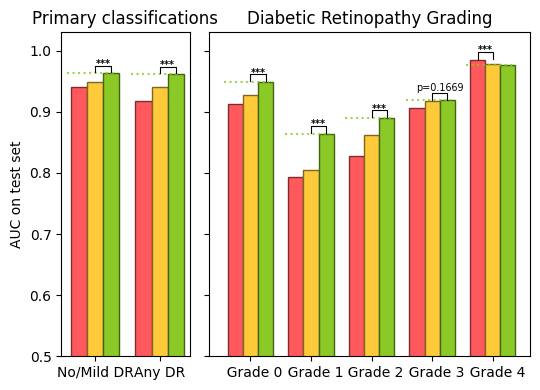

Statistically significant wins:  {'RETFound-MEH': 1, 'DERETFound': 0, 'RETFound-Green': 5}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 1, 'RETFound-Green': 1}


In [3]:
run_brset_exp(name_X_list, models, colors)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.8551	No/Mild vs rest:0.7053	AnyDR:0.6617
Total time: 1.4723s / mean time: 0.4908s


  0%|          | 0/3 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.8756	No/Mild vs rest:0.7723	AnyDR:0.7662
Total time: 0.6887s / mean time: 0.2296s


  0%|          | 0/3 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.9095	No/Mild vs rest:0.7187	AnyDR:0.7780
Total time: 0.3265s / mean time: 0.1088s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-MEH,RETFound-MEH,0.8551,0.7053,0.6617,0.8723,0.9834,0.8797,0.8607
DERETFound,DERETFound,0.8756,0.7723,0.7662,0.8508,0.9614,0.9060,0.8910
RETFound-Green,RETFound-Green,0.9095,0.7187,0.7780,0.8346,0.9491,0.9182,0.9100


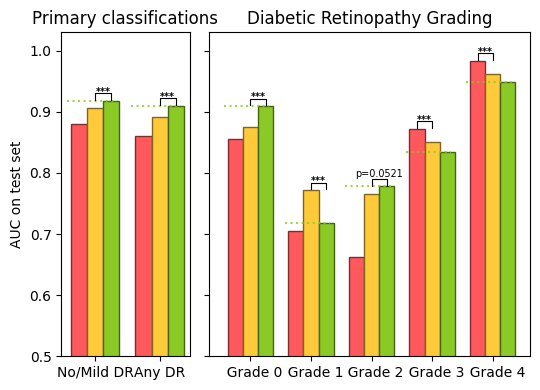

Statistically significant wins:  {'RETFound-MEH': 2, 'DERETFound': 1, 'RETFound-Green': 3}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 1, 'RETFound-Green': 1}


In [4]:
run_brset_exp(name_X_list, models, colors, diab_only=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.9128	No/Mild vs rest:0.7933	AnyDR:0.8276
Total time: 12.7213s / mean time: 4.2404s


  0%|          | 0/3 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.9270	No/Mild vs rest:0.8053	AnyDR:0.8620
Total time: 8.7054s / mean time: 2.9018s


  0%|          | 0/3 [00:00<?, ?it/s]

  RETFound-Green@224:DR Grade:0.9227	No/Mild vs rest:0.7967	AnyDR:0.8890
Total time: 4.0860s / mean time: 1.3620s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-MEH,RETFound-MEH,0.9128,0.7933,0.8276,0.9067,0.9854,0.9409,0.9178
DERETFound,DERETFound,0.9270,0.8053,0.8620,0.9172,0.9785,0.9494,0.9409
RETFound-Green@224,RETFound-Green@224,0.9227,0.7967,0.8890,0.9023,0.9694,0.9499,0.9308


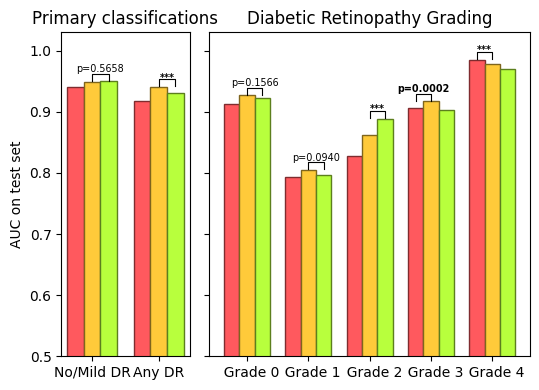

Statistically significant wins:  {'RETFound-MEH': 1, 'DERETFound': 2, 'RETFound-Green@224': 1}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 3, 'RETFound-Green@224': 3}


In [5]:
name_X_list = [
    ('RETFound-MEH', '/home/justin/RETFound_MAE/BRSET_RETFound_Feature_latent.npy'),
    ('DERETFound', '/home/justin/RETFound_MAE/BRSET_DERETFound_Feature_latent.npy'),
    ('RETFound-Green@224', 'X_ours_brset_224.npy'),
]
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green@224']
colors = ['#ff595e', '#ffca3a', '#B8FF3D']

run_brset_exp(name_X_list, models, colors)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.8551	No/Mild vs rest:0.7053	AnyDR:0.6617
Total time: 1.1146s / mean time: 0.3715s


  0%|          | 0/3 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.8756	No/Mild vs rest:0.7723	AnyDR:0.7662
Total time: 1.7645s / mean time: 0.5882s


  0%|          | 0/3 [00:00<?, ?it/s]

  RETFound-Green@224:DR Grade:0.8889	No/Mild vs rest:0.6757	AnyDR:0.8110
Total time: 0.4907s / mean time: 0.1636s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-MEH,RETFound-MEH,0.8551,0.7053,0.6617,0.8723,0.9834,0.8797,0.8607
DERETFound,DERETFound,0.8756,0.7723,0.7662,0.8508,0.9614,0.9060,0.8910
RETFound-Green@224,RETFound-Green@224,0.8889,0.6757,0.8110,0.8072,0.9675,0.9161,0.8862


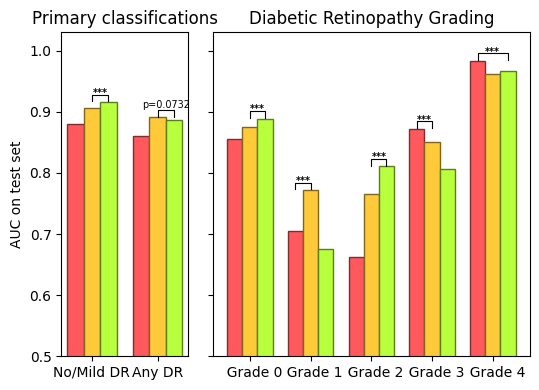

Statistically significant wins:  {'RETFound-MEH': 2, 'DERETFound': 1, 'RETFound-Green@224': 3}
Ties for first place:  {'RETFound-MEH': 0, 'DERETFound': 1, 'RETFound-Green@224': 1}


In [6]:
run_brset_exp(name_X_list, models, colors, diab_only=True)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.9095	No/Mild vs rest:0.7187	AnyDR:0.7780
Total time: 0.5730s / mean time: 0.1910s


  0%|          | 0/3 [00:00<?, ?it/s]

              DinoV2:DR Grade:0.8775	No/Mild vs rest:0.7069	AnyDR:0.7519
Total time: 0.3259s / mean time: 0.1086s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-Green,RETFound-Green,0.9095,0.7187,0.7780,0.8346,0.9491,0.9182,0.9100
DinoV2,DinoV2,0.8775,0.7069,0.7519,0.8136,0.9131,0.8957,0.8762


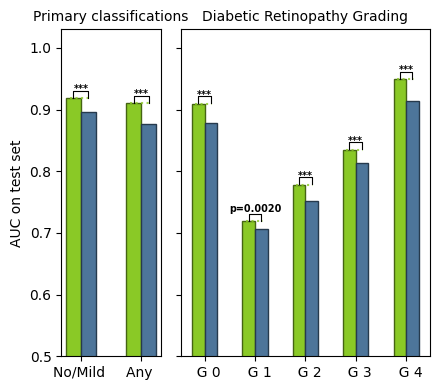

Statistically significant wins:  {'RETFound-Green': 7, 'DinoV2': 0}
Ties for first place:  {'RETFound-Green': 0, 'DinoV2': 0}


In [7]:
name_X_list = [
    ('RETFound-Green', 'X_ours_brset.npy'),
    ('DinoV2', 'X_ViTSDinov2_brset.npy'),
]

models = ['RETFound-Green', 'DinoV2']
colors = ['#8ac926', '#4d759a']

run_brset_exp(name_X_list, models, colors, diab_only=True,
              figsize=(4.5, 4), dashed_line_offsets=(-0.25, 1.1), xtick_loc_scaling=0.5, title_size='medium')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.9491	No/Mild vs rest:0.8644	AnyDR:0.8903
Total time: 3.2258s / mean time: 1.0753s


  0%|          | 0/3 [00:00<?, ?it/s]

              DinoV2:DR Grade:0.9353	No/Mild vs rest:0.7987	AnyDR:0.8730
Total time: 3.5303s / mean time: 1.1768s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-Green,RETFound-Green,0.9491,0.8644,0.8903,0.9189,0.9773,0.9635,0.9617
DinoV2,DinoV2,0.9353,0.7987,0.8730,0.8963,0.9563,0.9518,0.9427


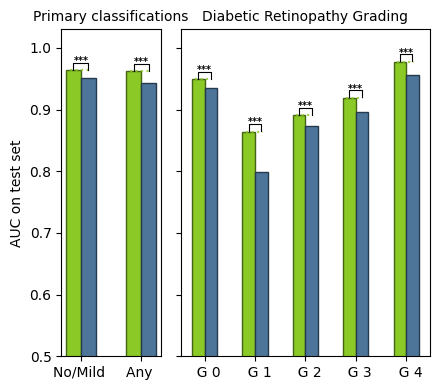

Statistically significant wins:  {'RETFound-Green': 7, 'DinoV2': 0}
Ties for first place:  {'RETFound-Green': 0, 'DinoV2': 0}


In [8]:
run_brset_exp(name_X_list, models, colors, diab_only=False,
              figsize=(4.5, 4), dashed_line_offsets=(-0.25, 1.1), xtick_loc_scaling=0.5, title_size='medium')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  RETFound-Green@224:DR Grade:0.8889	No/Mild vs rest:0.6757	AnyDR:0.8110
Total time: 0.4714s / mean time: 0.1571s


  0%|          | 0/3 [00:00<?, ?it/s]

          DinoV2@224:DR Grade:0.8614	No/Mild vs rest:0.6799	AnyDR:0.7596
Total time: 1.6851s / mean time: 0.5617s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-Green@224,RETFound-Green@224,0.8889,0.6757,0.8110,0.8072,0.9675,0.9161,0.8862
DinoV2@224,DinoV2@224,0.8614,0.6799,0.7596,0.7744,0.9511,0.8973,0.8646


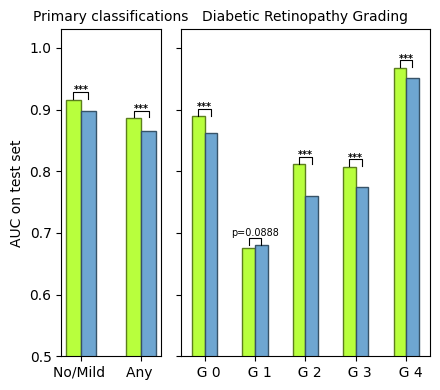

Statistically significant wins:  {'RETFound-Green@224': 6, 'DinoV2@224': 0}
Ties for first place:  {'RETFound-Green@224': 1, 'DinoV2@224': 1}


In [9]:
name_X_list = [
    ('RETFound-Green@224', 'X_ours_brset_224.npy'),
    ('DinoV2@224', 'X_original_dinov2_224_brset.npy'),
]


models = ['RETFound-Green@224', 'DinoV2@224']
colors = ['#B8FF3D', '#6EA6D1']

run_brset_exp(name_X_list, models, colors, diab_only=True,
              figsize=(4.5, 4), dashed_line_offsets=(-0.25, 1.5), xtick_loc_scaling=0.5, title_size='medium')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  RETFound-Green@224:DR Grade:0.9227	No/Mild vs rest:0.7967	AnyDR:0.8890
Total time: 2.6891s / mean time: 0.8964s


  0%|          | 0/3 [00:00<?, ?it/s]

          DinoV2@224:DR Grade:0.9232	No/Mild vs rest:0.7569	AnyDR:0.8833
Total time: 3.7883s / mean time: 1.2628s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,No/Mild vs rest,AnyDR
RETFound-Green@224,RETFound-Green@224,0.9227,0.7967,0.8890,0.9023,0.9694,0.9499,0.9308
DinoV2@224,DinoV2@224,0.9232,0.7569,0.8833,0.9030,0.9746,0.9474,0.9263


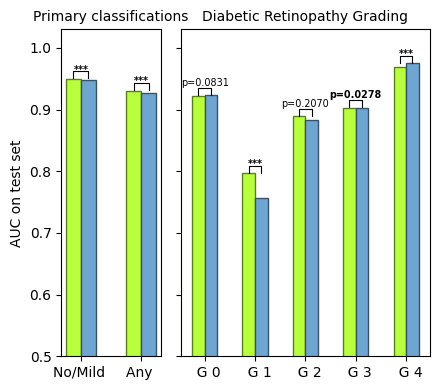

Statistically significant wins:  {'RETFound-Green@224': 3, 'DinoV2@224': 2}
Ties for first place:  {'RETFound-Green@224': 2, 'DinoV2@224': 2}


In [10]:
run_brset_exp(name_X_list, models, colors, diab_only=False,
              figsize=(4.5, 4), dashed_line_offsets=(-0.25, 1.5), xtick_loc_scaling=0.5, title_size='medium')